<a href="https://colab.research.google.com/github/sevwal/BME362_image_analysis/blob/main/BME362_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BME362: Image Processing**
We will be running a relatively simple image processing pipeline. As I'm not aware of your skill levels in coding, this script is meant to be fancy enough to excite you but simple enough to follow through easily - at least I hope so. Of course, I will be here to help you throughout the course should you have any questions!

We will make use of the open source functionalities of Python. One powerful aspect of Python is the easy install of the abundant packages and dependencies that suit your needs. And of course: the large community that codes all of this and makes it accessible to you for free :D We will mainly make use of the following packages:

*   [`OpenCV`](https://github.com/opencv/opencv/wiki) (Open Source Computer Vision Library) is a tool for computer vision and machine learning. It provides us with some powerful algorithms to process our images.
*   [`Cellpose`](https://github.com/MouseLand/cellpose) is a tool for image segmentation of cells and nuclei. It provides us with the ability to train a neural network for image segmentation. Don't worry, we won't go that deep in this short training and will make use of the pre-trained models cellpose provides to us. For more information, check out their [paper](https://www.biorxiv.org/content/10.1101/2022.04.01.486764v1).
*   [`scikit-image`](https://scikit-image.org/) an open-source image processing library for Python.



---



Remarks: This script was inspired by the documentation on [Cellpose](https://github.com/MouseLand/cellpose) and their example notebooks, workflows developed by Joel Lüthi ([Twitter](https://twitter.com/joel_luethi), [Github](https://github.com/jluethi)), as well as the notebook [Running cellpose 2.0 in colab with a GPU](https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb#scrollTo=Q7c7V4yEqDc_).


# **Preliminaries**

## **Step 1:** Get your files in here
Due to file size limitations, we will change the workflow as it was previously planned. We will now download only well D05 (the one we're interested in), and segment that well.

In order to do that, we will download the images directly from a Dropbox folder containing these images.import os
  if (not os.path.exists("/content/BME362_data")):
      os.mkdir("/content/BME362_data")

In [3]:
import os

#create new folder for our data
if (not os.path.exists("/content/BME362_data")):
    os.mkdir("/content/BME362_data")

#download files as .zip
!wget https://www.dropbox.com/sh/tg683owkitc8bxo/AABi_1Z6gtW2_xzrwe5Ahco9a?dl=0 --content-disposition -P "/content/BME362_data"

#unzip .zip
!unzip "/content/BME362_data/round2_well_D05.zip" -d "/content/BME362_data"

#delete .zip
!rm "/content/BME362_data/round2_well_D05.zip"

--2022-09-30 10:53:16--  https://www.dropbox.com/sh/tg683owkitc8bxo/AABi_1Z6gtW2_xzrwe5Ahco9a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/tg683owkitc8bxo/AABi_1Z6gtW2_xzrwe5Ahco9a [following]
--2022-09-30 10:53:17--  https://www.dropbox.com/sh/raw/tg683owkitc8bxo/AABi_1Z6gtW2_xzrwe5Ahco9a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc894c24c95692cb0edcb17e074e.dl.dropboxusercontent.com/zip_download_get/BRXCeNP3lvDt6WCe4SNtkdRLaV5FP8Ak3UAr0mOesROgvSKXv8Y8Ai9iSGIFa3DNO6JjD87SqAaw0rOFKizLQgDbBBLJ64eTSFqvMMsafOr6lw# [following]
--2022-09-30 10:53:17--  https://uc894c24c95692cb0edcb17e074e.dl.dropboxusercontent.com/zip_download_get/BRXCeNP3lvDt6WCe4SNtkdRLaV5FP8Ak3UAr0mOesROgvSKXv8Y8Ai9iSGIFa3DNO6JjD87SqAaw0rOFKizLQgDbBBLJ

## **Step 2:** Setup Cellpose and Import Libraries
Run the code below to install OpenCV and the GPU version of Cellpose.

After installation, you will get an error that your runtime has crashed. **Do not worry this is part of the plan!** <br>

<img src=https://static01.nyt.com/images/2016/08/05/us/05onfire1_xp/05onfire1_xp-superJumbo-v2.jpg
width=400> 

In [4]:
#!pip install git+https://www.github.com/mouseland/cellpose.git #to install development version
!pip install cellpose
!pip install torch torchvision torchaudio

#Fix opencv error: ImportError: cannot import name '_registerMatType' from 'cv2.cv2'
!pip install "opencv-python-headless<4.3"
exit(0) #Restart Runtime to use newly installed numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 5.2 MB/s 
     |████████████████████████████████| 31.0 MB 54.0 MB/s 
     |████████████████████████████████| 4.2 MB 32.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 83.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


As with all Python packages, installing is not enough. We need to import (and thus load) them to make them available for us to use with the code below. We will need some basics and dependencies (Numpy, time, os sys, random), along with our plotting tool (matplotlib.pyplot), and some additional things.

In [1]:
#disabled installation and import of mxnet as pytorch is the default neural net
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import shutil

## **Step 3:** Check GPU access and download Cellpose Models
Next up, we will download the pre-trained models from cellpose. Cellpose comes with the following pre-trained models:

*   Cytoplasm (`cyto`)
*   Cytoplasm2 (`cyto2`)
*   Cytoplasm2_Omnipose (`cyto2_omni`)
*   Bacteroa_Omnipose (`bact_omni`)
*   Nuclei (`nuclei`)

`Cytoplasm` and `Cytoplasm2` are two differently trained cytoplasm models (remember that these models are neural networks!). We can use either one but depending on your cells one may perform better than the other. The model for `nuclei` is pretty solid, as nuclei shapes are very similar across cell types.

`Omnipose` uses a different algorithm to provide robust segmentation of elongated cell shapes (such as certain bacteria and other cells). We will not need this here.

We will also check for GPU access to speed up our process if that's available. If you want to know more about why graphical processing units are important when working with neural networks, check out this [website](https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d).

In [2]:
print ("Downloading Models")
from cellpose import models,core
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

#Check if colab notebook instance has GPU access
if core.use_gpu()==False: 
  #Warnings from the ZeroCost StarDist notebook
  print(BOLD+UNDERLINE+'You do not have GPU access.'+END)
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
  use_GPU=False
else:
  print(BOLD+UNDERLINE+"You have access to the GPU."+END+"\nDetails are:")
  print("*************************************************")
  !nvidia-smi
  use_GPU=True

print("*************************************************")
print("Libraries imported and configured")

You do not have GPU access.
Did you change your runtime ?
If the runtime setting is correct then Google did not allocate a GPU for your session
Expect slow performance. To access GPU try reconnecting later
*************************************************
Libraries imported and configured


## **Step 4:** Prepare your paths
In Step 1 you made sure your images can be accessed with this script. Now's the time to use them: 

*   Enter the full path as `Input_Directory` below. You can simply copy the path from the file viewer on the left side and paste it here.
*   Provide the format of the image (PNG, TIF, JPEG, GIF, ...) as `image_format`. 

In [3]:
#Specify input directory
Input_Directory = "/content/BME362_data" #@param {type:"string"}
input_dir = os.path.join(Input_Directory, "") #adds separator to the end regardless if path has it or not

#Specify image format
image_format = "png" #@param {type:"string"}

#Create a new folder where we will store our mask(s)
save_dir = input_dir+"Masks/"
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

#Create a new folder where we will store our merged images
merge_dir = input_dir+"Merged/"
if not os.path.exists(merge_dir):
  os.makedirs(merge_dir)

#### **Interlude: Image formats**
In general, image analysis is always only recommended for ***lossless image formats*** such as ***TIF*** or ***PNG***. Jpeg is considered a lossy format, as it deletes part of the information in your images to compress them more. For more information, Wikipedia's page on image compression is pretty good (https://en.wikipedia.org/wiki/Image_compression).

As you should have seen, we will always use naming conventions to orient ourselves in the gazillion of images we take. The simplest solution now is to just throw everything into one folder, read that into `Python` as a path, and then access the files through loops and changing pathnames. Like this, you never have to specify individual files, which is helpful if you're dealing with a lot of images.

#### **Also, this:**
If you're having a tough time or just really need something for your ADHD needs, let's make life a little easier, shall we? Head to `Settings` (the gear in the upper right corner), then click `Miscellaneous`, and use any combination of `Corgi mode`, `Kitty mode`, and/or `Crab mode`. („• ᴗ •„)	

##**Step 5:** Merge images
For the following code, we need to merge the channels of our images into one image with multiple channels. This is because segmenting with cellpose works best when images are merged.

*   In the code itself, specify the `wells` and `channels` you are using in the following format ["A", "B", ...].

In [4]:
#Specify wells
wells = ["D05"]

#Specify number of sites
number_of_sites = 25

#Loop through every site for every well and merge the channels into one image. 
#The channels are hardcoded, so please adjust the if there are more or less than 3 channels
for well in wells:
  for site in range(1,number_of_sites+1):
    ch1 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C01.png" % (well, site),-1)
    ch2 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C02.png" % (well, site),-1)
    ch4 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C04.png" % (well, site),-1)
    merged = cv2.merge([ch4, ch2, ch1])
    cv2.imwrite(input_dir + "Merged/" +
                "29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01_merged.png" % (well, site), merged)

#### Interlude: Looping through folders and naming things
You might notice that the code in **step 5** was written in a way such that we loop through the folder containing our raw images and then merge all images that belong to the same well and site. Now you might realize why the naming conventions for image data are so useful. If metadata information is already in the filename, we can easily access and process files using just the filenmae.

This is why coding makes life so much easier for us in image analysis: We can create functions that are automatically and equally applied to all of our data! 


## **Step 6**: Read and Load all the images, check a merged image
In this step we will check our images. As always, we would like to check if everything is set up correctly before blindly heading into later steps. So this will allow us to see if we are working with the correct images and double check the channel names for later. The code below will select a random image from the folder you provided and display all the channels of it.

**Note:** *We do not need to do anything here*, we can simply run this code as  all necessary variables are already specified. ٩(◕‿◕)۶


Number of images loaded: 25.
No of images loaded are:  25
Example Image:
29092022_HEK_CD48_confocal_round2_D05_T0001F013L01A01Z01_merged.png has 3 dimensions/s
Image: 29092022_HEK_CD48_confocal_round2_D05_T0001F013L01A01Z01_merged.png


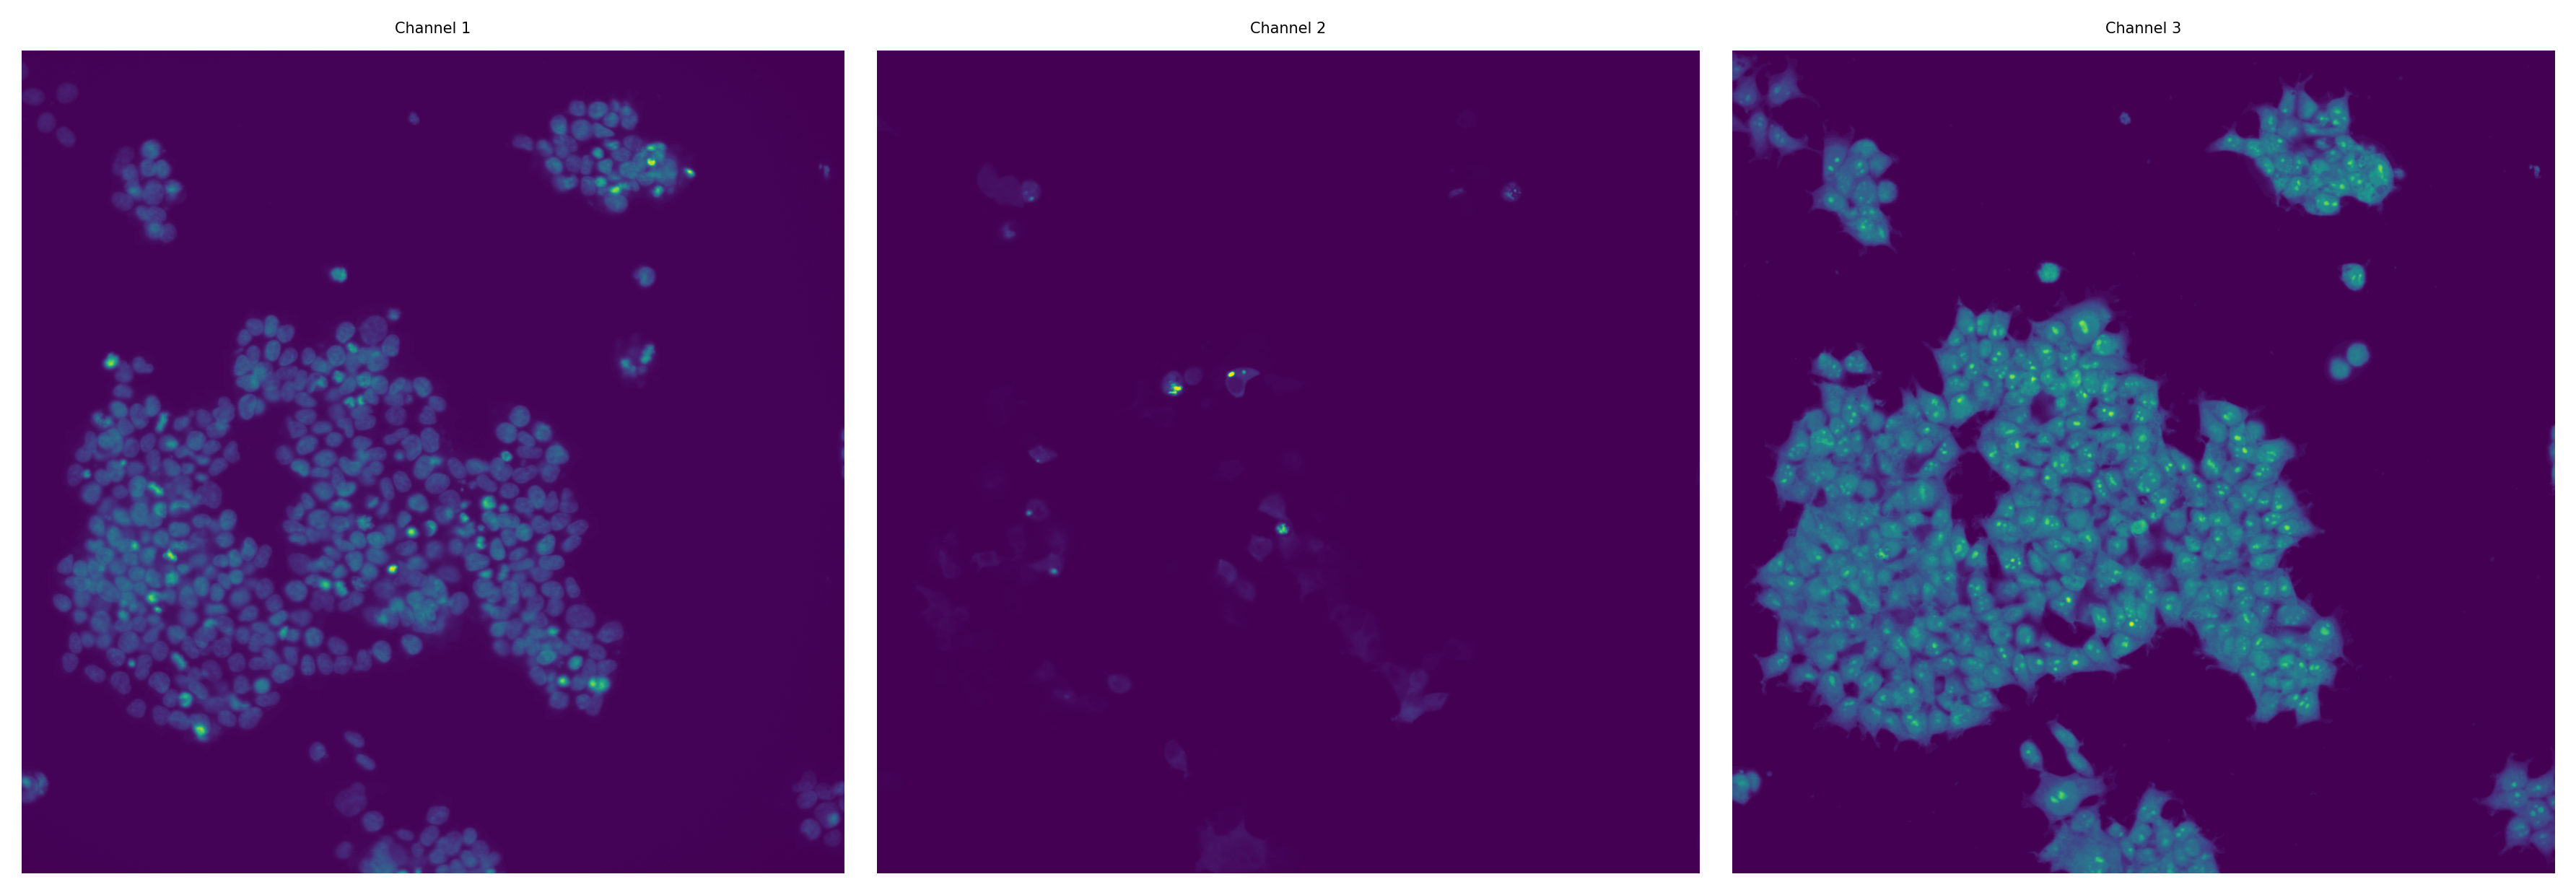

In [5]:
# r=root, d=directories, f = files
files=[]

for r, d, f in os.walk(merge_dir):
    for fil in f:
      if (image_format):
        if fil.endswith(image_format):
          files.append(os.path.join(r, fil))
      else:
        files.append(os.path.join(r, fil))
    break #only read the root directory; can change this to include levels
if(len(files)==0):
  print("Number of images loaded: %d." %(len(files)))
  print("Cannot read image files. Check if folder has images")
else:
  print("Number of images loaded: %d." %(len(files)))

imgs=[] #store all images
#Read images
for f in files:
  im=skimage.io.imread(f)
  n_dim=len(im.shape) #shape of image
  dim=im.shape #dimensions of image
  channel=min(dim) #channel will be dimension with min value usually
  channel_position=dim.index(channel)
  #if no of dim is 3 and channel is first index, swap channel to last index
  if n_dim==3 and channel_position==0: 
    #print(dim)
    im=im.transpose(1,2,0)
    dim=im.shape
    #print("Shape changed")
  #print(dim)
  imgs.append(im)

nimg = len(imgs)

print("Example Image:")

random_idx = random.choice(range(len(imgs)))
x=imgs[random_idx]
n_dim=len(x.shape)
file_name=os.path.basename(files[random_idx])
print(file_name+" has "+str(n_dim)+" dimensions/s")
if n_dim==3:
  channel_image=x.shape[2]
  fig, axs = plt.subplots(1, channel_image,figsize=(12,5))
  print("Image: %s" %(file_name))
  for channel in range(channel_image):
      axs[channel].imshow(x[:,:,channel])
      axs[channel].set_title('Channel '+str(channel+1),size=5)
      axs[channel].axis('off')
  fig.tight_layout()
elif n_dim==2:
  print("One Channel")
  plt.imshow(x)
else:
  print("Channel number invalid or dimensions wrong. Image shape is: "+str(x.shape))

# **Nuclear Segmentation**

## **Step 7:** Specify parameters for the nuclear segmentation
We now have to specify the parameters for the segmentation of the nuclei. So what's needed?

*   **Channel to run segmentation on**. Which channel did you use to save the DAPI stain in your merged image?
*   **Model Type**. What model type do we need to use?
*   **Diameter**. How large are the nuclei in *pixels*, approximately? If you enter 0, cellpose will automatically estimate them. You will also be prompted to specify it later on, as well.



In [6]:
#Specify Channel
Channel_for_segmentation="1" #@param[1,2,3]
segment_channel=int(Channel_for_segmentation)

Use_nuclear_channel= False

#Specify Model
Model_Choice = "Nuclei" #@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei"]
model_choice=Model_Choice

print("Using model ",model_choice)


#Diameter of cell (pixels):
Diameter =  0#@param {type:"number"}
diameter=Diameter

if model_choice=="Cytoplasm":
  model_type="cyto"

elif model_choice=="Cytoplasm2":
  model_type="cyto2"

elif model_choice=="Cytoplasm2_Omnipose":
  model_type="cyto2_omni"

elif model_choice=="Bacteria_Omnipose":
  model_type="bact_omni" 
  diameter = 0

elif model_choice=="Nuclei":
  model_type="nuclei" 


# channels = [cytoplasm, nucleus]
if model_choice not in "Nucleus":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type=model_type)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
if diameter is 0:
  diameter = None
  print("\nDiameter is set to None. The size of the cells will be estimated on a per image basis")

Using model  Nuclei


100%|██████████| 25.3M/25.3M [00:00<00:00, 59.4MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 1.38MB/s]


Diameter is set to None. The size of the cells will be estimated on a per image basis


## **Step 8:** Test the nuclear segmentation
Next up, we want to check out how we're doing so far. Naturally, you don't want to run your code for all of your images only to then realise that you ran it with weird parameters. So, in order to do that, we need to specify one of the images we want to use for testing and give some additional parameters.



*   `Image_Number`: Which of your images you want to use for the test (starts at 1).
*   `Diameter`: The diameter of what you'd like to segment (roughly). This was optional before but is highly useful now.
*   `Flow_Threshold`: Maximum error for the "flows" for each mask. **Increase** to discard more cells, e.g. in range from (0.1, 3.0), or set to 0.0 to turn off so no cells are discarded.
*   `Cell_Probability_Threshold`: The probability threshold of a pixel being part of a cell. **Decrease** to include more pixels or **increase** to include fewer, e.g. in range from (-6, 6).

Naturally, we would not expect to get the parameters perfect in one go. Moreover, this depends on our cells, the experiment, and many more. So please go ahead and **fine-tune these parameters until you are satisfied with your segmentation**. 

*Can you see any nuclei that were not segmented? Why do you think that is? Could you improve it by tweaking the parameters above?*


Image: /content/BME362_data/Merged/29092022_HEK_CD48_confocal_round2_D05_T0001F011L01A01Z01_merged.png


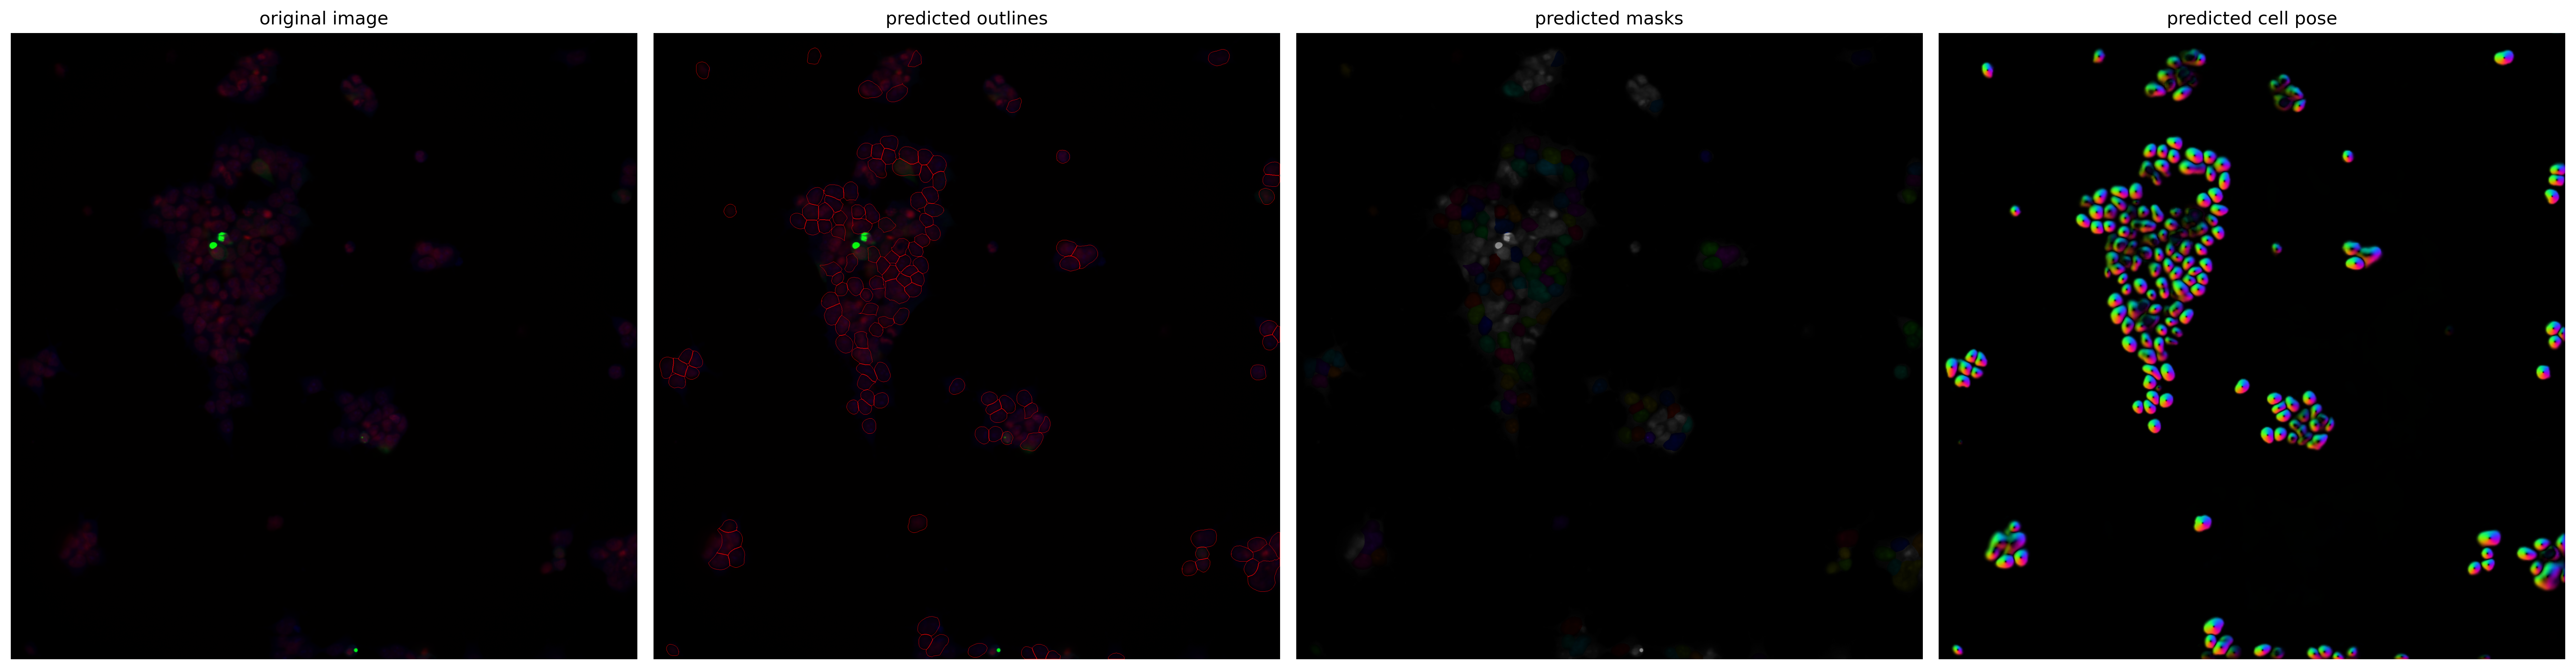

In [10]:
from skimage.util import img_as_ubyte

#Specify Image Number
Image_Number =  1#@param {type:"number"}
Image_Number-=1 #indexing starts at zero

#Specify Diameter
Diameter = 60#@param {type:"number"}
diameter=Diameter

#Specify Flow_Threshold
Flow_Threshold = 0.5 #@param {type:"slider", min:0.0, max:1.1, step:0.1}
flow_threshold=Flow_Threshold

#Specify Cell_Probability_Threshold (Using slider to restrict values)
Cell_Probability_Threshold=-3 #@param {type:"slider", min:-6, max:6, step:1}
cellprob_threshold=Cell_Probability_Threshold


if diameter is 0:
  diameter = None
if Image_Number is -1:
  Image_Number=0
  #print("Image_Number is set to zero, opening first image.")
try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(files[Image_Number]))
img1=imgs[Image_Number]

masks, flows, styles, diams = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)

# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, img1, maski, flowi, channels=channels)
plt.tight_layout()
plt.show()

## **Step 9:** Run the nuclear segmentation
**Now it's up to you:** If you're happy, run the segmentation on all your nuclei and save the output as mask images with the regular filename but "`_NUC_MASK`" at the end. To do that, simply run the code below. It may take a couple of seconds, so go and stretch a bit, get some fresh air, and stay hydrated while your computer does the work.

Onwards to the cytoplasm!

In [13]:
print("Running segmentation on channel %s" %(segment_channel))
print("Using the model: ",model_choice)
if diameter is None:
  print("Diameter will be estimated from the image/s")
else:
  print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

#if too many images, it will lead to memory error. 
#will evaluate on a per image basis
#masks, flows, styles, diams = model.eval(imgs, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)


#save images in folder with the diameter value used in cellpose
print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ",save_dir)
if (not os.path.exists(save_dir)):
    os.mkdir(save_dir)


for img_idx, img in enumerate(imgs):
    file_name=os.path.splitext(os.path.basename(files[img_idx]))[0]
    print("\nSegmenting: ",file_name)
    mask, flow, style, diam = model.eval(img, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=channels)
    #save images in folder with the diameter value used in cellpose
    print("Segmentation complete . Saving Masks and flows")
    #Output name for masks
    mask_output_name=save_dir+file_name+"_NUC_MASK"+".png"
    print(mask_output_name)
    #Save mask as 16-bit in case this has to be used for detecting more than 255 objects
    mask=mask.astype(np.uint16)
    #Save flow as 8-bit
    skimage.io.imsave(mask_output_name, mask, check_contrast=False)

#Save parameters used in Cellpose
parameters_file=save_dir+"Cellpose_nuclear_parameters_used.txt" 
outFile=open(parameters_file, "w") 
outFile.write("CELLPOSE PARAMETERS\n") 
outFile.write("Model: "+model_choice+"\n") 
if diameter == 0:
  diameter = "Automatically estimated by cellpose"
outFile.write("Diameter: "+str(diameter)+"\n") 
outFile.write("Flow Threshold: "+str(flow_threshold)+"\n") 
outFile.write("Cell probability Threshold: "+str(cellprob_threshold)+"\n") 
outFile.close() 
print("\nSegmentation complete and files saved")

Running segmentation on channel 1
Using the model:  Nuclei
Cellpose will use a diameter of 60
Using a flow threshold of: 0.5 and a cell probability threshold of: -3
Segmentation Done. Saving Masks and flows now
Save Directory is:  /content/BME362_data/Masks/

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F011L01A01Z01_merged


KeyboardInterrupt: ignored

# **Cytoplasmic Segmentation**

## **Step 10:** Specify parameters for the cytoplasmic segmentation
We now have to specify the parameters for the segmentation of the cytoplasm. Again, let's take a look at the parameters we need:

*   **Model Type**. What model type do we need to use?
*   **Channel_for_segmentation**: Which channel did you use to save the Succs stain in your merged image?
*   **Use_nuclear_channel**: Before, this option was not given. If we segment the cytoplasm, we can choose to specify a nuclear channel, which will greatly help cytoplasmic segmentation.
*   **Diameter**. How large are the cells in *pixels*, approximately? Same as before, if you leave it at 0 cellpose will estimate them.

This is a repeat of what we did for the nuclei, with no major twists. The main difference here is that we choose a different model, and supply cellpose with the nuclear channel to help the cytoplasmic segmentation. *Food for thought: Why do you think that this helps?*

In [28]:
#Specify Channel
Channel_for_segmentation="3" #@param[1,2,3]
segment_channel=int(Channel_for_segmentation)

Use_nuclear_channel= True #@param {type:"boolean"}
Nuclear_channel="1" #@param[1,2,3]
nuclear_channel=int(Nuclear_channel)

#Specify Model
Model_Choice = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei"]
model_choice=Model_Choice

print("Using model ",model_choice)

# Diameter of cell (pixels):
Diameter =  0#@param {type:"number"}
diameter=Diameter

if model_choice=="Cytoplasm":
  model_type="cyto"

elif model_choice=="Cytoplasm2":
  model_type="cyto2"

elif model_choice=="Cytoplasm2_Omnipose":
  model_type="cyto2_omni"

elif model_choice=="Bacteria_Omnipose":
  model_type="bact_omni" 
  diameter = 0

elif model_choice=="Nuclei":
  model_type="nuclei" 


# channels = [cytoplasm, nucleus]
if model_choice not in "Nucleus":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type=model_type)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
if diameter is 0:
  diameter = None
  print("\nDiameter is set to None. The size of the cells will be estimated on a per image basis")

Using model  Cytoplasm

Diameter is set to None. The size of the cells will be estimated on a per image basis


## **Step 11:** Test the cytoplasmic segmentation
Very much analogous to what we did when we segmented the nuclei. I'm sure you'll still remember what these parameters meant! As before, do try **fine-tuning the parameters** and give cellpose a proper test run. 

*Again, are there some cells that ar not or wrongly segmented? Do you see any reason why that could be (think of the shape of the cells, their cellular state, ...)?*

In [29]:
from skimage.util import img_as_ubyte

#Specify Image Number
Image_Number =  1#@param {type:"number"}
Image_Number-=1 #indexing starts at zero

#Specify Diameter
Diameter = 80#@param {type:"number"}
diameter=Diameter

#Specify Flow_Threshold
Flow_Threshold = 0.7 #@param {type:"slider", min:0.0, max:1.1, step:0.1}
flow_threshold=Flow_Threshold

#Specify Cell_Probability_Threshold (Using slider to restrict values)
Cell_Probability_Threshold=-1 #@param {type:"slider", min:-6, max:6, step:1}
cellprob_threshold=Cell_Probability_Threshold


if diameter is 0:
  diameter = None
if Image_Number is -1:
  Image_Number=0
  #print("Image_Number is set to zero, opening first image.")
try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(files[Image_Number]))
img1=imgs[Image_Number]

import cv2

masks, flows, styles, diams = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)



# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, img1, maski, flowi, channels=channels)
plt.tight_layout()
plt.show()

Image: 29092022_HEK_CD48_confocal_round2_D05_T0001F011L01A01Z01_merged.png


KeyboardInterrupt: ignored

## **Step 12:** Run the cytoplasmic segmentation
Once again we're back to running our segmentation on the cytoplasm. Again, if you're happy with cellpose's performance, run the segmentation on the cytoplasm. The masks will be saved in the MASK folder with the same filename but "`_CYT_MASK`" at the end.

In [30]:
print("Running segmentation on channel %s" %(segment_channel))
print("Using the model: ",model_choice)
if diameter is None:
  print("Diameter will be estimated from the image/s")
else:
  print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

#if too many images, it will lead to memory error. 
#will evaluate on a per image basis
#masks, flows, styles, diams = model.eval(imgs, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)


#save images in folder with the diameter value used in cellpose
print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ",save_dir)
if (not os.path.exists(save_dir)):
    os.mkdir(save_dir)


for img_idx, img in enumerate(imgs):
    file_name=os.path.splitext(os.path.basename(files[img_idx]))[0]
    print("\nSegmenting: ",file_name)
    mask, flow, style, diam = model.eval(img, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)
    #save images in folder with the diameter value used in cellpose
    print("Segmentation complete . Saving Masks and flows")
    #Output name for masks
    mask_output_name=save_dir+file_name+"_CYT_MASK"+".png"
    #Save mask as 16-bit in case this has to be used for detecting than 255 objects
    mask=mask.astype(np.uint16)
    #Save flow as 8-bit
    skimage.io.imsave(mask_output_name,mask, check_contrast=False)
    
#Save parameters used in Cellpose
parameters_file=save_dir+"Cellpose_cyto_parameters_used.txt" 
outFile=open(parameters_file, "w") 
outFile.write("CELLPOSE PARAMETERS\n") 
outFile.write("Model: "+model_choice+"\n") 
if diameter == 0:
  diameter = "Automatically estimated by cellpose"
outFile.write("Diameter: "+str(diameter)+"\n") 
outFile.write("Flow Threshold: "+str(flow_threshold)+"\n") 
outFile.write("Cell probability Threshold: "+str(cellprob_threshold)+"\n") 
outFile.close() 
print("\nSegmentation complete and files saved")

Running segmentation on channel 3
Using the model:  Cytoplasm
Cellpose will use a diameter of 80
Using a flow threshold of: 0.7 and a cell probability threshold of: -1
Segmentation Done. Saving Masks and flows now
Save Directory is:  /content/BME362_data/Masks/

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F011L01A01Z01_merged
Segmentation complete . Saving Masks and flows

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F006L01A01Z01_merged
Segmentation complete . Saving Masks and flows

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F016L01A01Z01_merged
Segmentation complete . Saving Masks and flows

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F001L01A01Z01_merged
Segmentation complete . Saving Masks and flows

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F019L01A01Z01_merged
Segmentation complete . Saving Masks and flows

Segmenting:  29092022_HEK_CD48_confocal_round2_D05_T0001F014L01A01Z01_merged
Segmentation complete . Saving Mask

# *In case of a runtime error or restart*
It might be that we had a break at this point and your runtime ended. To avoid having to run the entire code again, we will first load all the important packages and paths again. If you saved everything in your Google Drive, just reload that again.

In [ ]:
#Importing packages previously loaded
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import shutil

#Specify input directory
Input_Directory = "/content/drive/MyDrive/BME362_images" #@param {type:"string"}
input_dir = os.path.join(Input_Directory, "") #adds separator to the end regardless if path has it or not
save_dir = input_dir+"Masks/"
merge_dir = input_dir+"Merged/"

#Specify image format
image_format = "png" #@param {type:"string"}

# r=root, d=directories, f = files
files=[]

for r, d, f in os.walk(input_dir):
    for fil in f:
      if (image_format):
        if fil.endswith(image_format):
          files.append(os.path.join(fil))
      else:
        files.append(os.path.join(fil))
    break #only read the root directory; can change this to include levels
if(len(files)==0):
  print("Number of images loaded: %d." %(len(files)))
  print("Cannot read image files. Check if folder has images")
else:
  print("Number of images loaded: %d." %(len(files)))

Number of images loaded: 4.


#I**mage Analysis**
So, what have we done so far? We have taken our raw images and, without any preprocessing, segmented our cells into both nuclei and cytoplasm using a clever package called `cellpose`. These segmentations (or masks) are now saved as .png images. So far so good.

In the coming part, we will not really be using the nuclear segmentations, as what you're trying to look at does not need them. We will continue with the cytoplasmic segmentations, clean them up, and then extract features per cell. This will allow us to get the data necessary for plotting our data and trying to answer the question we have. 

As before, we first test before heading into applying our code to all the images. As such, the code below will once again randomly select one of your images, along with its segmentations.

Make sure to enter the channel of the images where you want to make measurements.

In [18]:
#This redoes the merge, since the previous merge only took 3 channel

#Specify wells
wells = ["D05"]

#Specify number of sites
number_of_sites = 25

#Loop through every site for every well and merge the channels into one image. 
#The channels are hardcoded, so please adjust the if there are more or less than 3 channels
for well in wells:
  for site in range(1,number_of_sites+1):
    ch1 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C01.png" % (well, site),-1)
    ch2 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C02.png" % (well, site),-1)
    ch3 = cv2.imread(input_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01C03.png" % (well, site),-1)
    merged = cv2.merge([ch3, ch2, ch1])
    cv2.imwrite(input_dir + "Merged/" +
                "29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01_merged.png" % (well, site), merged)

In [19]:
#Chooses a random image from your input directory
files = []

for fil in os.listdir(merge_dir):
  f = os.path.join(merge_dir, fil)
  # checking if it is a file, this is to ignore any folders from being seen as a file
  if os.path.isfile(f):
      files.append(os.path.basename(f))

random_idx = random.choice(range(len(files)))

#Read signal and segmentation
signal = cv2.imread(merge_dir+files[random_idx], cv2.IMREAD_UNCHANGED)
cyt_seg = cv2.imread(save_dir + os.path.splitext(files[random_idx])[0] + "_CYT_MASK.png",-1)

## **Step 13:** Filtering
Now, when we extract information we want to be certain that the cells are **1) whole** (i.e. not cut off by the image border). If we don't, this will influence our analysis as all cell attributes (shape, size, signal,...) are affected by this. To do this, we will So in short, we don't want to measure shitty data, so we filter these cells first. Again, `skimage` has a wonderfully easy function for that called [`segmentation.clear_border`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.clear_border).

There are additional filtering steps we can take, for example to filter by size (or morphology). This removes any weird non-cellular objects (i.e. debris) that were segmented. However, as we are measuring stuff later on, this step becomes much easier in a bit. Moreover, cellpose is quite robust, if the parameters are chosen well. Other segmentation procedrures like the [watershed method](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) would require more cleanup.

In [20]:
from skimage import segmentation

#Clear the labels of cells touching the border of the image (i.e. set to zero)
cyt_seg_filtered = segmentation.clear_border(cyt_seg)

AttributeError: ignored

## **Step 14:** Feature Extraction
So, we think everything looks good in our images, we have filtered our cells, how can we now extract information from these images? 

If you take a look at your images in FIJI, Each cell or nucleus segmentation now has a different pixel value on that mask image. This allows us to extract all the coordinates of a cell by accessing only the pixels of that specific value.

Now, how we go about extracting this information on a per-cell-basis is up to us and there's many different options available. The best option depends on what you are doing and what you want from it. For this exercise, however, we will resort to a nice function of the excellent package `skimage` called [`measure.regionprops`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops). 

We can provide this function with our *label image* (=mask image) and our *signal image* that we want to measure from. The code below will report how many properties are available for measurement. Now you need to decide which of them you need for your analysis (*hint: as with any function, consult its documentation!*).

In [27]:
from skimage import measure

#List Available properties from measure.regionprops()
cyt_regionprops = measure.regionprops(cyt_seg_filtered, intensity_image=signal)
print("Available properties:")
print("  " + "\n  ".join(cyt_regionprops[0]))

NameError: ignored

Once you have selected some that might be of interest, put them in the corresponding spot in the code below. You might notice that the code looks a little bit different, but don't worry. It's essentially the same code as above (`measure.regionprops(label, intensity_image=image)`) but formats the output to a dataframe that is easier to use.

Looking at the output, what do you notice?

In [ ]:
import pandas as pd

cyt_measurements = pd.DataFrame(
    measure.regionprops_table(
        cyt_seg_filtered,
        intensity_image=signal,
        properties=['label', 'area', 'min_intensity', 'mean_intensity', 'max_intensity', 'solidity', 'coords']
        )
).set_index('label')
cyt_measurements.head()

area  min_intensity-0  min_intensity-1  min_intensity-2  \
label                                                            
1      4153              391              750               97   
2      6672              457              375               91   
3      5042              431              391               90   
4      3585              356              378               93   
5      3505              368              281               82   

       min_intensity-3  mean_intensity-0  mean_intensity-1  mean_intensity-2  \
label                                                                          
1                  316       3239.063809       2371.829762        423.373947   
2                  364       3777.126499        609.642986        129.224820   
3                  364       3850.943078        616.661047        129.712019   
4                  353       3293.577964        659.816179        130.854951   
5                  231       2436.510128        419.497575        117.090442   

       mean_intensity-3  max_intensity-0  max_intensity-1  max_intensity-2  \
label                                                                        
1           3058.304358             7343            12469              801   
2           2369.864808             9943              887              170   
3           2796.682467             9183             1028              170   
4           3761.203626             5891             2233              172   
5           1630.759486             6446              578              157   

       max_intensity-3  solidity  \
label                              
1                 8865  0.964244   
2                 6831  0.914348   
3                 7844  0.961847   
4                16868  0.984079   
5                 4930  0.932429   

                                                  coords  
label                                                     
1      [[235, 941], [235, 942], [235, 943], [235, 944...  
2      [[858, 1011], [858, 1012], [858, 1013], [858, ...  
3      [[868, 1055], [868, 1056], [868, 1057], [868, ...  
4      [[1197, 1467], [1197, 1468], [1197, 1469], [11...  
5      [[1666, 1989], [1666, 1990], [1666, 1991], [16...

## **Step 15:** Loop through all images
With all of this set, we can now do what we did above for all of our images. This essentially follows the same structure, except it is now in a loop. Additionally, we will save the measurements for each site into a CSV file.

**Note:** Make sure to modify the code below such that you use the same specifications and parameters as above.

In [32]:
#Create folder to store measurements
measurement_dir = os.path.join(input_dir, "Measurements")
if (not os.path.exists(measurement_dir)):
  os.mkdir(measurement_dir)

#Specify wells
wells = ["D05"]

#Specify number of sites
number_of_sites = 25

#Loop through every site for every well and merge the channels into one image. 
#The channels are hardcoded, so please adjust the if there are more or less than 3 channels
for well in wells:
  for site in range(1,number_of_sites+1):
    signal = cv2.imread(merge_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01_merged.png" % (well, site), cv2.IMREAD_UNCHANGED)
    cyt_seg = cv2.imread(save_dir+"29092022_HEK_CD48_confocal_round2_%s_T0001F%03dL01A01Z01_merged_CYT_MASK.png" % (well, site),-1)
  
    #Clear the labels of cells touching the border of the image (i.e. set to zero)
    cyt_seg_filtered = segmentation.clear_border(cyt_seg)

    #Extract Features and store in pd.DataFrame
    cyt_measurements = pd.DataFrame(
        measure.regionprops_table(
            cyt_seg_filtered,
            intensity_image=signal,
            properties=['label', 'area', 'min_intensity', 'mean_intensity', 'max_intensity', 'solidity', 'coords']
            )
    ).set_index('label')
    #Add Well and Site info to dataframe
    cyt_measurements["well"] = well
    cyt_measurements["site"] = site

    #Save measurements to CSV file
    cyt_measurements.to_csv(os.path.join(measurement_dir,
                                         "15092022_ZNFX1_testAB_%s_T0001F0%02dL01A01Z01_measurements.csv" % (well, site)))
    

To avoid loading all of the CSV files for our analysis, we can combine all of them into one. The code below quickly reads all your csv files that we generated previously and then combines them into one single file called `combined_measurements.csv`.

In [31]:
import glob
all_filenames = [i for i in sorted(glob.glob(measurement_dir+"/*.csv"))]
combined_measurements = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_measurements = combined_measurements.reset_index()
combined_measurements.to_csv(os.path.join(measurement_dir, "combined_measurements.csv"), index=False, encoding='utf-8-sig')

NameError: ignored

# **Data Analysis**
You now have a large dataframe with many different variables. This final part of the task is very much up to you: Explore your data, try some plots, see if you can find anything of interest. If you're more familiar with R, you can of course also use R. An example scatterplot has been included below.

**Remember**: What was the original goal of this experiment? What parameters do we need to answer this question? Where can you find these parameters?

Also think back to your data analysis and programming courses: should you first do some quality checks on your data?

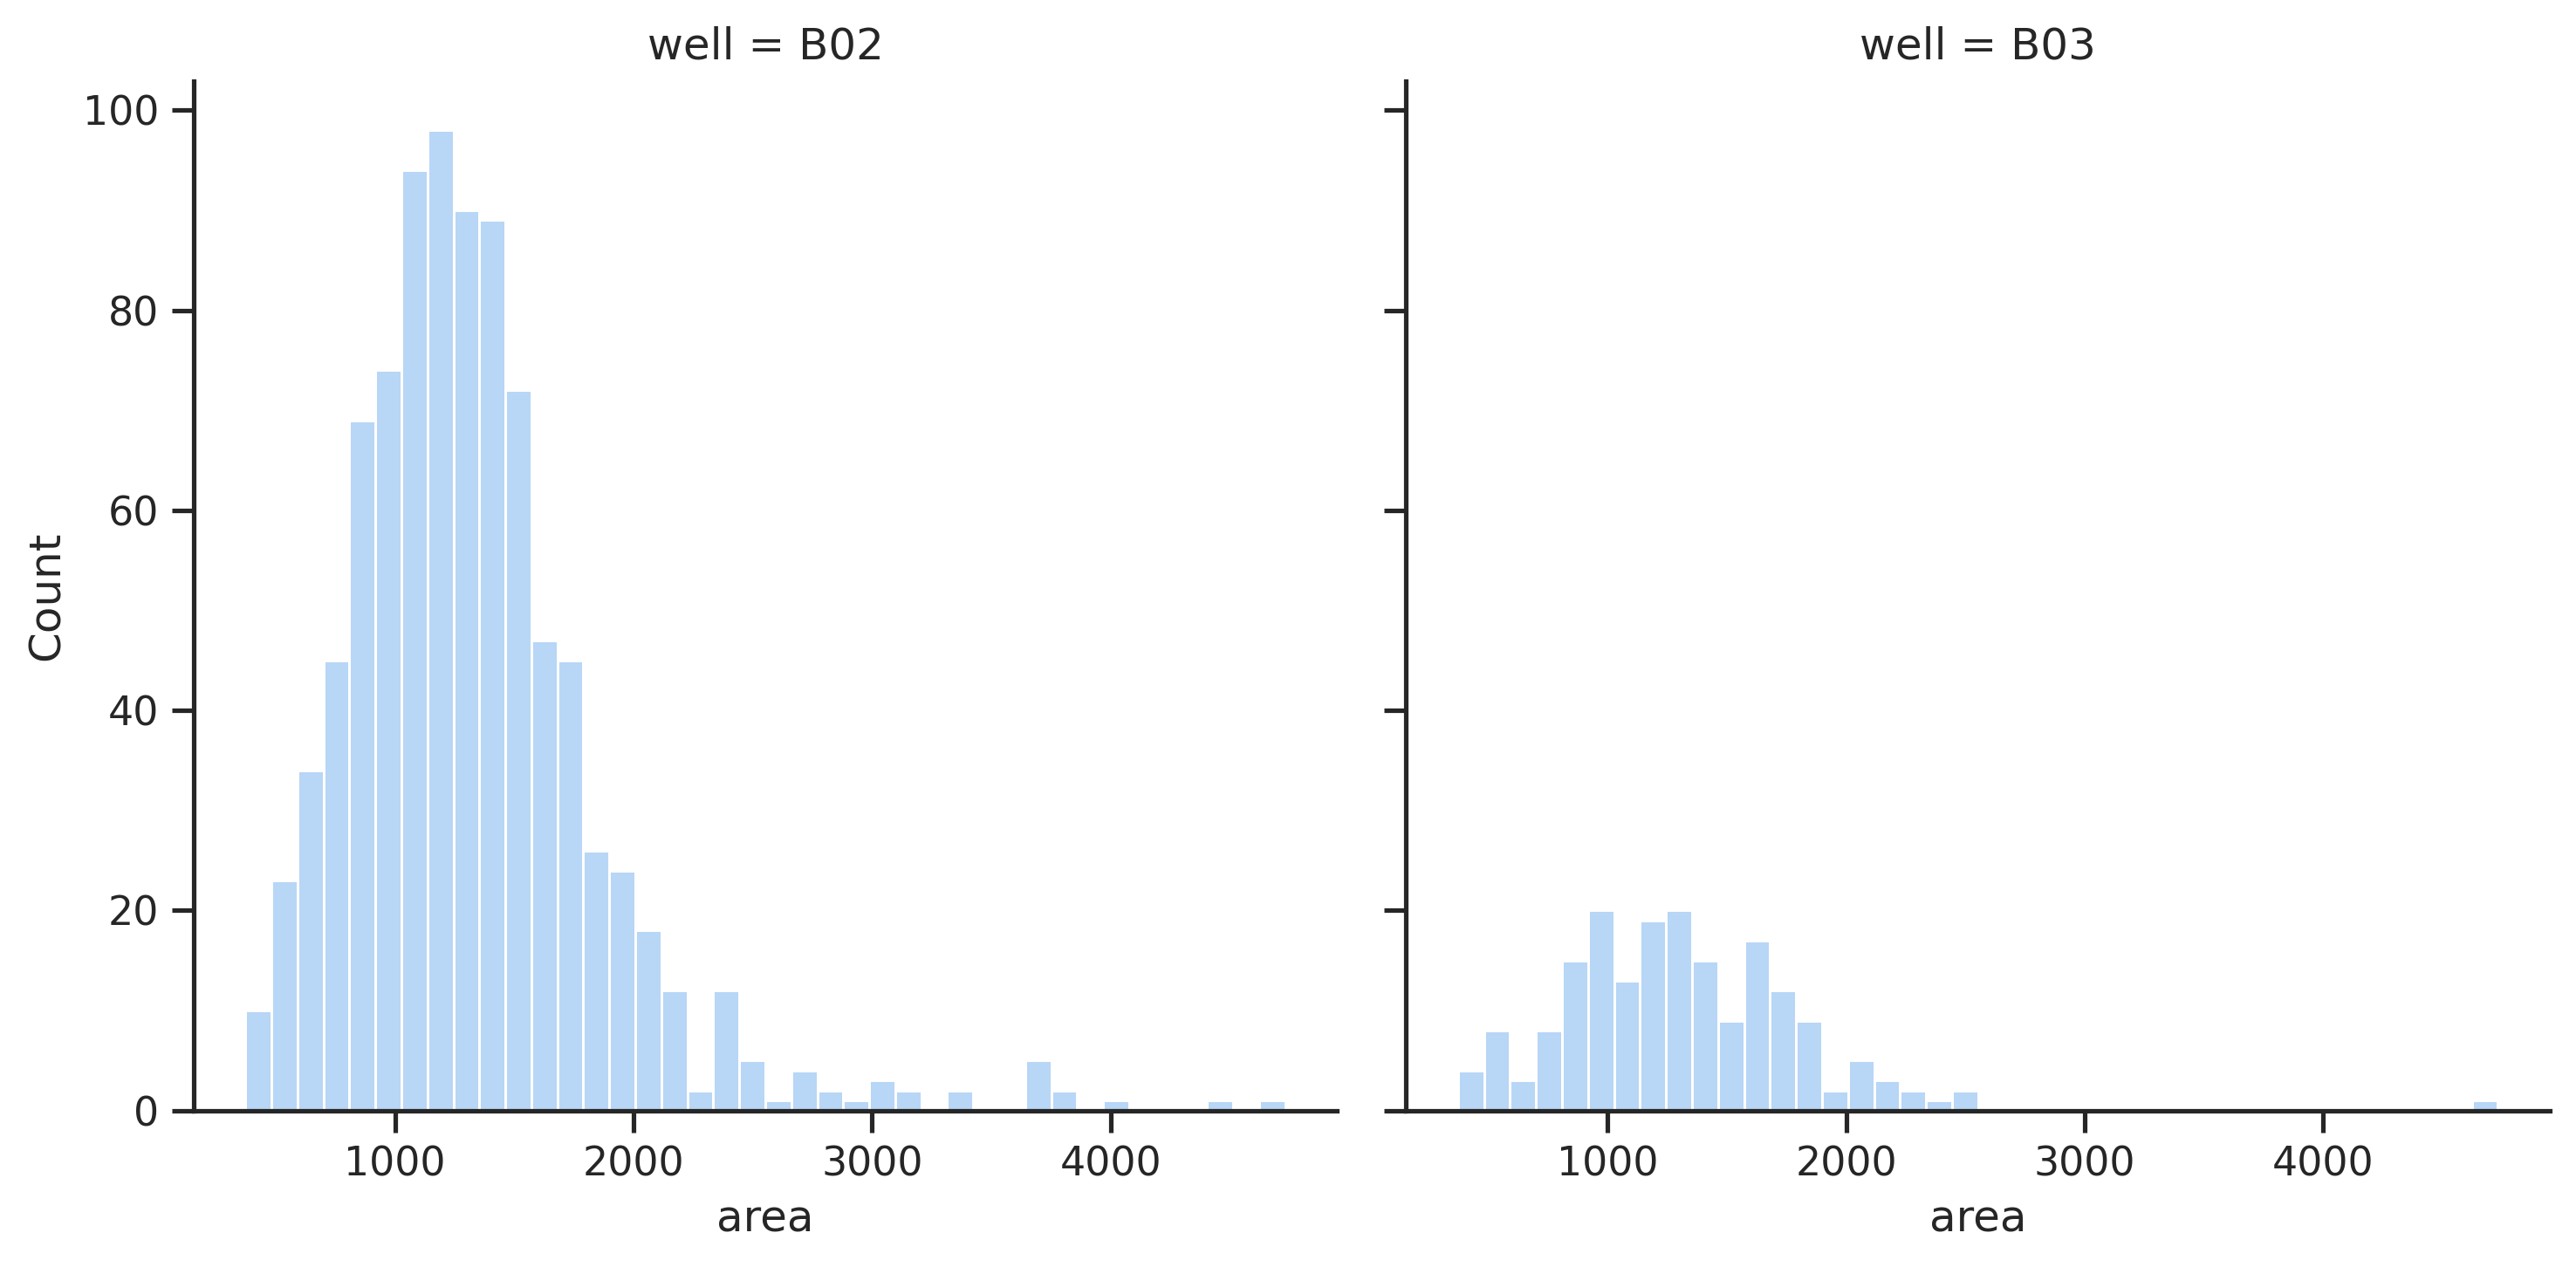

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Some ideas for plots:

# Compare the size of cells between wells
sns.displot(
    combined_measurements, x="area", col="well",
    facet_kws=dict(margin_titles=True),
)

# Compare the size of cells between wells
sns.boxplot(x="well", y="area",
            data=combined_measurements)
sns.despine(offset=10, trim=True)

# Compare the area and mean intensity of cells
sns.scatterplot(x='area', y='mean_intensity', data=combined_measurements, hue='mean_intensity')

In [34]:
!zip -r /content/BME362_data.zip /content/BME362_data
from google.colab import files
files.download("/content/BME362_data.zip")

  adding: content/BME362_data/ (stored 0%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F004L01A01Z01C03.png (deflated 0%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F018L01A01Z01C02.png (deflated 1%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F005L01A01Z01C03.png (deflated 0%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F016L01A01Z01C02.png (deflated 2%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F008L01A01Z01C02.png (deflated 2%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F011L01A01Z01C02.png (deflated 2%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F017L01A01Z01C03.png (deflated 0%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F015L01A01Z01C01.png (deflated 0%)
  adding: content/BME362_data/29092022_HEK_CD48_confocal_round2_D05_T0001F007L01A01Z01C04.png

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>